In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from scipy import random
from scipy.spatial.distance import cdist
from scipy.linalg import svd, eigvals
import networkx as nx
from kmm import KMMeans

# K-Multiple-Means

**Reference**:

Feiping Nie, Cheng-Long Wang, Xuelong Li, "K-Multiple-Means: A Multiple-Means Clustering Method with Specified K Clusters," in *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD'19)*, Anchorage, AK, USA, August 4–8, 2019.

## 1 Dataset

### 1.1 Two Moons

In [3]:
X, y = make_moons(n_samples=200, noise=0.10, random_state=1337)

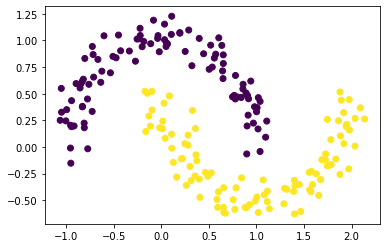

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y);

## 2 Algorithm

### 2.1 General Algorithm

<img src='algorithm.PNG'>

### 2.2 Implementation (one pass)

In [55]:
# Set initial parameters
k = 2                      # Cluster number
kt = 5                     # Number of neighbor prototypes
m_init = 'kmeans'          # m initialization; kmeans or random
m = 'auto'                 # Set number of prototypes; 'auto' or int

# Set derived parameters
n = len(X)                 # Number of data points
d = X.shape[1]             # Number of dimensions

if m == 'auto':
    m = int((n*k)**0.5)    # Number of subclusters/prototypes

# Initialization of matrix A
if m_init == 'kmeans':
    A = KMeans(m, random_state=1337).fit(X).cluster_centers_
else:
    A = X[random.choice(range(len(X)), size=m, replace=False)]

#### Get $\gamma$ and $S$

**Parameter $\gamma$**

\begin{equation}
\gamma = \frac{1}{n} \sum_{i=1}^n \left( \frac{\tilde{k}}{2} d^{th}_{i, \tilde{k}+1} - \frac{1}{2} \sum_{j=1}^{\tilde{k}}d_{ij}^{th}\right) \tag{1}
\end{equation}

**Matrix $S$**

\begin{equation}
s_{i\tilde{j}} = \frac{d_{i, \tilde{k} + 1}^{th} - d_{i\tilde{j}}^{th}}{\tilde{k}d^{th}_{i, \tilde{k}+1} - \sum_{j=1}^{\tilde{k}} d_{i\tilde{j}}^{th}} \tag{2}
\end{equation}

In [56]:
def get_S(d_ij, kt):
    """Return S and gamma given distance to prototype matrix and kt setting"""
    # Get argsorted indices
    idx = np.ogrid[:n, :m]
    idx[1] = d_ij.argsort(axis=1)
    idx = tuple(idx)

    # Get numerator & denominator value of S, and gamma (sorted).
    d_th = d_ij[idx]
    denom = (kt*d_th[:, kt] - d_th[:, :kt].sum(axis=1))
    gamma = (1 / (2*n) * denom).sum()
    nume = (d_th[:, kt].reshape(n, -1) - d_th[:, :kt])
    s = nume / denom.reshape(n, -1)
    
    # Store values in the unsorted matrix
    s = np.pad(s, ((0, 0), (0, m - kt)))
    S = np.zeros((n, m))
    S[idx] = s
    
    return S, gamma

In [57]:
# Get distance to prototype matrix
d_ij = cdist(X, A)**2

# Get S and gamma
S, gamma = get_S(d_ij, kt)

In [58]:
# Get argsorted indices
idx = np.ogrid[:n, :m]
idx[1] = d_ij.argsort(axis=1)
idx = tuple(idx)

# Get numerator & denominator value of S, and gamma.
d_th = d_ij[idx]
denom = (kt*d_th[:, kt] - d_th[:, :kt].sum(axis=1))
gamma = (1 / (2*n) * denom).sum()
nume = (d_th[:, kt].reshape(n, -1) - d_th[:, :kt])
s = nume / denom.reshape(n, -1)
s = np.pad(s, ((0, 0), (0, m - kt)))
S = np.zeros((n, m))
S[idx] = s

#### Update $F$

$$
F = \begin{bmatrix} U \\ V \end{bmatrix} \tag{3}
$$

$U$ and $V$ are the left and right singular vectors of $D_U^{-\frac{1}{2}} S D_V^{-\frac{1}{2}}$

Where 

$$
P = \begin{bmatrix}  & S \\ S^T & \end{bmatrix} \tag{4}
$$

and 

$$
d_{ii} = \sum_j p_{ij} \tag{5}
$$

and

$$
D = \begin{bmatrix} D_U & \\  & D_V \end{bmatrix} \tag{6}
$$

In [59]:
def get_FD(S):
    """Return matrix F, D, and eigenvalues (sigma) of L_S given S"""
    # Matrix P
    P = np.block([[np.zeros((n, n)), S],
                  [S.T, np.zeros((m, m))]])

    # Matrix D
    D = np.diag(P.sum(axis=1)**-0.5)
    D_U = D[:n, :n]
    D_V = D[-m:, -m:]

    # Perform SVD on the multiplied matrix
    U, sigma, Vh = svd(D_U @ S @ D_V, full_matrices=False)

    # Get F
    F = np.block([[U[:, :k]], [Vh.T[:, :k]]]) / 2**0.5
    
    return F, D, sigma

In [60]:
F, D, sigma = get_FD(S)

In [61]:
# Matrix P
P = np.block([[np.zeros((n, n)), S],
              [S.T, np.zeros((m, m))]])

# Matrix D
D = np.diag(P.sum(axis=1)**-0.5)
D_U = D[:n, :n]
D_V = D[-m:, -m:]

# Perform SVD on the multiplied matrix
U, sigma, Vh = svd(D_U @ S @ D_V, full_matrices=False)

# # Get F
F = np.block([[U[:, :k]], [Vh.T[:, :k]]]) / 2**0.5

#### Update S

$$
v_{ij} = \left \Vert \frac{f_i}{\sqrt{d_i}} - \frac{f_{(n+j)}}{\sqrt{d_{(n+j)}}} \right \Vert _2^2 \tag{7}
$$

In [62]:
def get_v(F, D):
    """Return matrix v given F and D"""
    # Get first and second term of the norm
    f1 = F[:n] * (D.sum(1)[:n]).reshape(n, -1)
    f2 = F[n:] * (D.sum(1)[n:]).reshape(m, -1)
    
    # Calculate v
    v = cdist(f1, f2)**2
    
    return v

In [63]:
v = get_v(F, D)

In [64]:
f1 = F[:n] * (D.sum(1)[:n]).reshape(n, -1)
f2 = F[n:] * (D.sum(1)[n:]).reshape(m, -1)
v = cdist(f1, f2)**2

$$
\tilde{d}_{ij} = d_{ij}^x + \lambda v_{ij} \tag{8}
$$

In [65]:
def get_growth_factor(sigma, rate=2):
    """Return lambda growth factor given eigenvalues (sigma)"""
    # Count number of zero eigenvalues
    zeros = (np.isclose(sigma, 1)).sum()
    
    # Look up table, if num_zeros > k, < k, or = k.
    if zeros < k:
        return rate
    elif zeros > k:
        return 1/rate
    else:
        return 0

In [66]:
gf = get_growth_factor(sigma)
lambd = gf*gamma
d_tild = d_ij + lambd*v

Updated $S$

In [67]:
S_new = get_S(d_tild, 5)[0]

#### Update $A$

$$
a_j = \frac{\sum_{i=1}^n s_{ij} x_i}{\sum_{i=1}^n s_{ij}}
$$

In [68]:
def get_A(S, X):
    """Return updated A given S and X"""
    return ((S.reshape((n, m, 1))*X.reshape((n, 1, d))).sum(0) 
            / (S.sum(0).reshape(-1, 1)))

In [69]:
A_new = get_A(S_new, X)

### 2.3 Implementation (Full Algo)

#### Initialization

In [70]:
# Set initial parameters
k = 2                       # Cluster number
kt = 5                      # Number of neighbor prototypes
m_init = 'kmeans'           # m initialization; kmeans or random
m = 'auto'                  # Set number of prototypes; 'auto' or int
m = 30
tol = 1e-4                  # Tolerance for terminating condition
sub_n_iters = 60            # Additional terminating conditions
n_iters = 15                # Additional terminating conditions
growth_rate = 1.10          # Growth rate

# Set derived parameters
n = len(X)                 # Number of data points
d = X.shape[1]             # Number of dimensions

# Initialize terminating condition (Mean Square Error)
MSE = np.inf

if m == 'auto':
    m = int((n*k)**0.5)    # Number of subclusters/prototypes

# Initialization of matrix A
if m_init == 'kmeans':
    A = KMeans(m, random_state=1337).fit(X).cluster_centers_
else:
    A = X[random.choice(range(len(X)), size=m, replace=False)]

#### Iterations

<img src=algorithm.PNG>

In [71]:
# Set number of iterations
n_iter = 0

# Set terminating condition (main loop)
while (MSE > tol) & (n_iter < n_iters):
    # Get distance to prototype matrix
    d_ij = cdist(X, A)**2

    # Get S and gamma
    S, gamma = get_S(d_ij, kt)
    
    # Initialize lambda
    lambd = gamma
    
    # Initialize sub_n_iter
    sub_n_iter = 0
    
    # Perform sub-iteration procedure
    while (sub_n_iter < sub_n_iters):
        # Get F, D, and eigenvalues
        F, D, sigma = get_FD(S)
        
        # Get growth factor
        gf = get_growth_factor(sigma, growth_rate)
        
        # Break loop if gf == 0
        if gf == 0:
            break

        # Get v
        v = get_v(F, D)
        
        # Get lambda and d_tilde
        lambd = gf*lambd
        d_tild = d_ij + lambd*v
        
        # Update S and gamma
        S, gamma = get_S(d_tild, kt)
        
        # Add iteration
        sub_n_iter += 1
        
    # Update A
    A_new = get_A(S, X)
    
    # Get mean square error
    MSE = np.mean((A_new - A)**2)
    
    # Set to new variable
    A = A_new.copy()
    
    # Add iteration
    n_iter += 1

### 2.3 Results

#### Generate network plot

In [72]:
# Get edges matrix
P = np.block([[np.zeros((n, n)), S],
              [S.T, np.zeros((m, m))]])

# Generate network plot
G = nx.from_numpy_matrix(P)

#### Get connected components

In [73]:
res = []
for c in nx.connected_components(G):
    res.append(c)

#### Get y predictions

In [74]:
y_pred = np.zeros(len(X))
y_pred[list(res[1] - set(range(len(X), len(X) + m)))] = 1
y_prot = np.zeros(len(A))
y_prot[np.array(list(res[1] - set(range(0, len(X))))) - len(X)] = 1

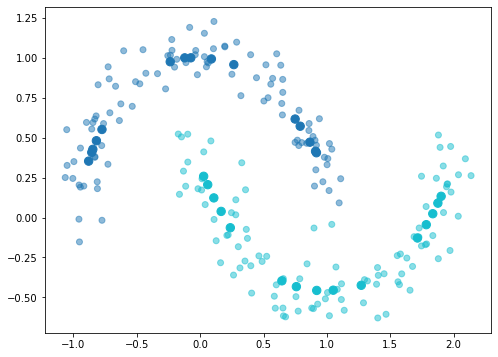

In [75]:
# Plot result
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', alpha=0.50)
plt.scatter(A[:, 0], A[:, 1], c=y_prot, cmap='tab10', s=70);

#### Get network connectivity plot

In [76]:
weights = [G[u][v]['weight'] for u,v in G.edges()]

In [77]:
pos = np.concatenate((X, A))
colors = ['tab:blue' if i < 200 else 'tab:orange' for i in range(len(P))]

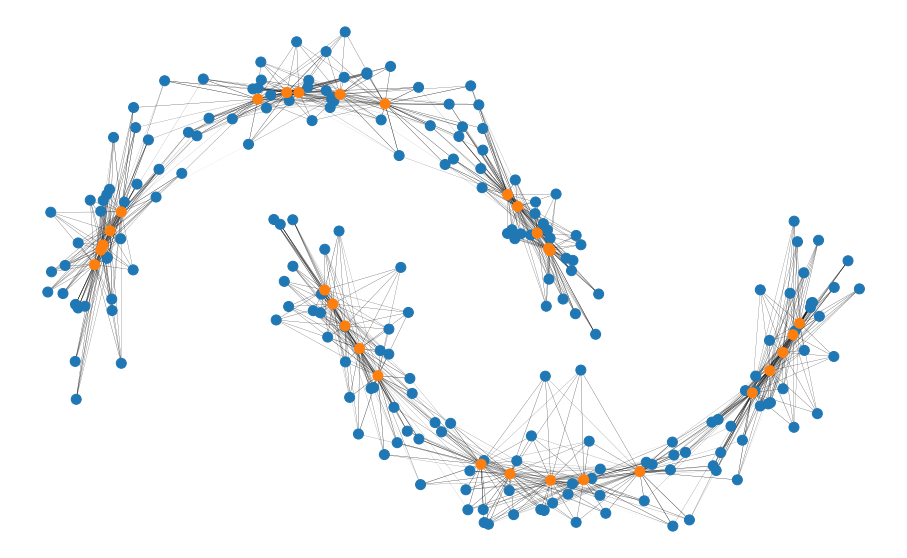

In [78]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
nx.draw(G, pos, width=weights, node_size=100, node_color=colors, ax=ax)

## 3 Modularized Implementation

### 3.1 From Notebook

In [79]:
class KMMeans:
    """
    Base class of the K Multiple Means clustering method
    
    Parameters
    ----------
    
    n_clusters : int, default=2
        The number of clusters to form.
    
    n_prototypes : int or 'auto', default='auto'
        Number of prototypes in clustering
        
    n_neighbors : int, default=5
        Number of neighbor prototype per data point
    
    init : {'kmeans', 'random'}, default=kmeans
        Initialization method:
        
        'kmeans' : Form initial clusters using KMeans
        
        'random' : Randomized initial points based on data
    
    tol : float
        Tolerance condition for the main loop of the algorithm
    
    sub_n_iters : int
        Maximum number of iteration for the sub iteration procedure
        i.e., controls how many attempts to split the graph into `n_clusters`
        connected components
    
    n_iters : int
        Maximum number of iteration for the whole procedure
    
    growth_rate : float
        Controls how fast the `lambda` value increases per sub iteration.
        
    Attributes
    ----------
    labels_ : ndarray of shape (n_samples,)
        Predicted label of each point
    
    prototypes_ : ndarray of shape (n_prototypes, n_features)
        Location of the prototypes
    
    prototype_labels_ : ndarray of shape(n_prototypes,)
        Labels of each prototype
    
    conn_proba_ : ndarray of shape (n_samples, n_prototypes)
        Connection probability of the data sample with the prototype.
        Matrix S in the reference.
    """
    
    def __init__(self, n_clusters=2, n_prototypes='auto', n_neighbors=5, 
                 init='kmeans', tol=1e-4, sub_n_iters=60, n_iters=15,
                 growth_rate=1.10):
        """Initialize K Multiple Means"""
        self.n_clusters = n_clusters
        self.n_neighbors = n_neighbors
        self.init = init
        self.n_prototypes = n_prototypes
        self.tol = tol
        self.sub_n_iters = sub_n_iters
        self.n_iters = n_iters
        self.growth_rate = growth_rate
    
    def fit(self, X):
        """
        Compute the k multiple means clustering
        
        Parameters
        ----------
        X : array-like
            Training instances to the cluster.
        """
        # Set initial parameters
        m = self.n_prototypes
        k = self.n_clusters
        kt = self.n_neighbors
        self.n_samples = len(X)
        
        # Set derived parameters
        n = self.n_samples         # Number of data points
        d = X.shape[1]             # Number of dimensions

        # Initialize terminating condition (Mean Square Error)
        MSE = np.inf

        if m == 'auto':
            m = int((n*k)**0.5)    # Number of subclusters/prototypes
            self.n_prototypes = m

        # Initialization of matrix A
        if self.init == 'kmeans':
            A = KMeans(m, random_state=1337).fit(X).cluster_centers_
        else:
            A = X[random.choice(range(len(X)), size=m, replace=False)]
        
        # Set number of iterations
        n_iter = 0

        # Set terminating condition (main loop)
        while (MSE > self.tol) & (n_iter < self.n_iters):
            # Get distance to prototype matrix
            d_ij = cdist(X, A)**2

            # Get S and gamma
            S, gamma = KMMeans.get_S(self, d_ij, kt)

            # Initialize lambda
            lambd = gamma

            # Initialize sub_n_iter
            sub_n_iter = 0

            # Perform sub-iteration procedure
            while (sub_n_iter < self.sub_n_iters):
                # Get F, D, and eigenvalues
                F, D, sigma = KMMeans.get_FD(self, S)

                # Get growth factor
                gf = KMMeans.get_growth_factor(self, sigma, self.growth_rate)

                # Break loop if gf == 0
                if gf == 0:
                    break

                # Get v
                v = KMMeans.get_v(self, F, D)

                # Get lambda and d_tilde
                lambd = gf*lambd
                d_tild = d_ij + lambd*v

                # Update S and gamma
                S, gamma = KMMeans.get_S(self, d_tild, kt)

                # Add iteration
                sub_n_iter += 1

            # Update A
            A_new = KMMeans.get_A(self, S, X)

            # Get mean square error
            MSE = np.mean((A_new - A)**2)

            # Set to new variable
            A = A_new.copy()

            # Add iteration
            n_iter += 1
        
        # Get results
        
        # Initialize results container
        y_pred = np.zeros(len(X))
        y_prot = np.zeros(len(A))
        
        # Get edges matrix
        P = np.block([[np.zeros((n, n)), S],
                      [S.T, np.zeros((m, m))]])

        # Generate network plot
        G = nx.from_numpy_matrix(P)
        
        # Iterate through connected components
        for i, c in enumerate(nx.connected_components(G)):
            # Get indices
            idx_data = list(c - set(range(len(X), len(X) + m)))
            idx_prototype = np.array(list(c - set(range(len(X))))) - len(X)
            
            # Record to results container
            y_pred[idx_data] = i
            y_prot[idx_prototype] = i
        
        # Record results to class
        self.prototypes_ = A
        self.conn_proba_ = S
        self.labels_ = y_pred
        self.prototype_labels_ = y_prot
        
    def get_S(self, d_ij, kt):
        """Return S and gamma given distance to prototype matrix and kt"""
        # Set derived parameters
        n = d_ij.shape[0]
        m = d_ij.shape[1]
        
        # Get argsorted indices
        idx = np.ogrid[:n, :m]
        idx[1] = d_ij.argsort(axis=1)
        idx = tuple(idx)

        # Get numerator & denominator value of S, and gamma (sorted).
        d_th = d_ij[idx]
        denom = (kt*d_th[:, kt] - d_th[:, :kt].sum(axis=1))
        gamma = (1 / (2*n) * denom).sum()
        nume = (d_th[:, kt].reshape(n, -1) - d_th[:, :kt])
        s = nume / denom.reshape(n, -1)

        # Store values in the unsorted matrix
        s = np.pad(s, ((0, 0), (0, m - kt)))
        S = np.zeros((n, m))
        S[idx] = s

        return S, gamma
    
    def get_FD(self, S):
        """Return matrix F, D, and eigenvalues (sigma) of L_S given S"""
        # Set derived parameters
        n = S.shape[0]
        m = S.shape[1]
        k = self.n_clusters
        
        # Matrix P
        P = np.block([[np.zeros((n, n)), S],
                      [S.T, np.zeros((m, m))]])

        # Matrix D
        D = np.diag(P.sum(axis=1)**-0.5)
        D_U = D[:n, :n]
        D_V = D[-m:, -m:]

        # Perform SVD on the multiplied matrix
        U, sigma, Vh = svd(D_U @ S @ D_V, full_matrices=False)

        # Get F
        F = np.block([[U[:, :k]], [Vh.T[:, :k]]]) / 2**0.5

        return F, D, sigma
    
    def get_growth_factor(self, sigma, rate=2):
        """Return lambda growth factor given eigenvalues (sigma)"""
        # Set derived parameters
        k = self.n_clusters
        
        # Count number of zero eigenvalues
        zeros = (np.isclose(sigma, 1)).sum()

        # Look up table, if num_zeros > k, < k, or = k.
        if zeros < k:
            return rate
        elif zeros > k:
            return 1/rate
        else:
            return 0
        
    def get_v(self, F, D):
        """Return matrix v given F and D"""
        # Set derived values
        n = self.n_samples
        m = self.n_prototypes
        
        # Get first and second term of the norm
        f1 = F[:n] * (D.sum(1)[:n]).reshape(n, -1)
        f2 = F[n:] * (D.sum(1)[n:]).reshape(m, -1)

        # Calculate v
        v = cdist(f1, f2)**2

        return v
    
    def get_A(self, S, X):
        """Return updated A given S and X"""
        # Set derived parameters
        n = X.shape[0]
        d = X.shape[1]
        m = self.n_prototypes
        
        return ((S.reshape((n, m, 1))*X.reshape((n, 1, d))).sum(0) 
                / (S.sum(0).reshape(-1, 1)))

In [84]:
kmm = KMMeans(n_prototypes=30)
kmm.fit(X)

In [85]:
y_pred = kmm.labels_
y_prot = kmm.prototype_labels_
A = kmm.prototypes_

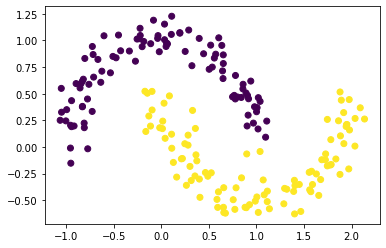

In [86]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

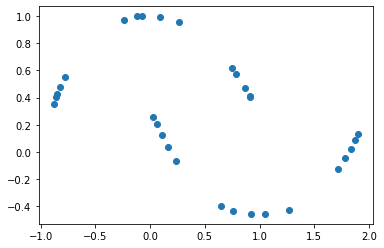

In [87]:
plt.scatter(A[:, 0], A[:, 1])

### 3.2 From import

In [5]:
kmm = KMMeans(n_prototypes=30)
kmm.fit(X)

In [6]:
y_pred = kmm.labels_
y_prot = kmm.prototype_labels_
A = kmm.prototypes_

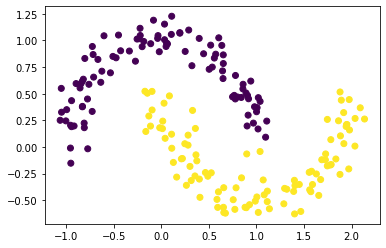

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

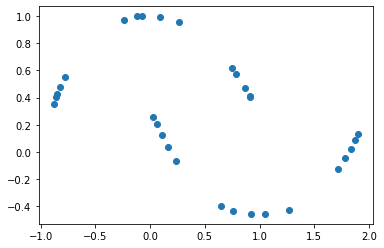

In [8]:
plt.scatter(A[:, 0], A[:, 1])